In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.autograd.functional import jacobian
from torch.autograd import grad

import foldingnet as FN
from pdb_data import PDBData

# LOAD ML MODEL AND DATA

In [2]:
path = "C:\\Users\\xdzl45\\workspace\\molearn_notebook\\data"

Load training data

In [4]:
data = PDBData()
data.import_pdb(f'{path}{os.sep}MurD_closed_selection.pdb')
data.import_pdb(f'{path}{os.sep}MurD_open_selection.pdb')
data.fix_terminal()
data.atomselect(atoms = ['CA', 'C', 'N', 'CB', 'O'])
data.prepare_dataset()
data_train, data_valid = data.split(manual_seed=25)

Dataset.shape: torch.Size([1800, 3, 2145])
mean: 44.62627486359321, std: 13.831951414894913


Load trained model

In [5]:
path = "C:\\Users\\xdzl45\\workspace\\molearn_notebook\\data"
networkfile = f'{path}{os.sep}checkpoint_no_optimizer_state_dict_epoch167_loss0.003259085263643.ckpt'

checkpoint = torch.load(networkfile, map_location=torch.device('cpu'))

net = FN.AutoEncoder(**checkpoint['network_kwargs'])
net.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

Encode training in model set to get boundary conditions for scan of grid deformation 

In [ ]:
data_train.dataset.shape

encoded = []
for i in range(len(data_train.dataset)):
    encoded.append(net.encode(data_train.dataset[i:i+1]).cpu())

encoded = np.array(encoded)

In [ ]:
min_x = np.min(encoded.shape)

In [ ]:
z = encoded[0]

z = z.requires_grad_(True)
output = net.decode(z)
print(output.shape)#[-1])

J = []
for i in range(output.shape[-1]):
    g = grad(outputs=output[:, :, i].sum(), inputs=z, retain_graph=True, create_graph=True)[0]
    if i%10 == 0:
        print(i)
    J.append(g)
    
J = torch.stack(J, dim=1)  # (batch, output_dim, latent_dim)


# GRID DEFORMATION ANALYSIS

We scan the latent space to assess local grid deformation

https://chatgpt.com/share/680ef247-ef50-8005-ab9b-0daf265dbe58

In [3]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from torch.autograd import grad

# ------------------------
# Core Riemannian functions
# ------------------------

def compute_jacobian(decoder, z):
    """Compute Jacobian of decoder output wrt latent z."""
    z = z.requires_grad_(True)
    output = decoder(z)
    J = []
    for i in range(output.shape[-1]):
        g = grad(outputs=output[:, :, i].sum(), inputs=z, retain_graph=True, create_graph=True)[0]
        J.append(g)
    J = torch.stack(J, dim=1)  # (batch, output_dim, latent_dim)
    return J

def pullback_metric(decoder, z):
    """Compute pullback metric G = J^T J."""
    J = compute_jacobian(decoder, z)
    G = torch.matmul(J.transpose(1, 2), J)  # (batch, latent_dim, latent_dim)
    return G

def metric_scalar_field(decoder, z, mode='determinant'):
    """Compute a scalar field from the metric."""
    G = pullback_metric(decoder, z)
    if mode == 'determinant':
        field = torch.linalg.det(G)
    elif mode == 'trace':
        field = torch.einsum('bii->b', G)
    elif mode == 'frobenius':
        field = torch.linalg.norm(G, dim=(1,2))
    else:
        raise ValueError(f"Unknown mode {mode}")
    return field

# ------------------------
# Sampling and Plotting
# ------------------------

def sample_latent_grid(grid_range=(-3, 3), steps=50, device='cpu'):
    """Sample a uniform grid over latent space."""
    x = torch.linspace(grid_range[0], grid_range[1], steps)
    y = torch.linspace(grid_range[0], grid_range[1], steps)
    X, Y = torch.meshgrid(x, y, indexing='ij')
    points = torch.stack([X.flatten(), Y.flatten()], dim=-1).to(device)
    return points, X, Y

def plot_scalar_field(X, Y, values, title='Riemannian Scalar Field'):
    """Plot heatmap and isolines of scalar field."""
    Z = values.reshape(X.shape).cpu().numpy()
    X = X.cpu().numpy()
    Y = Y.cpu().numpy()

    plt.figure(figsize=(8,6))
    cp = plt.contourf(X, Y, Z, levels=50, cmap='viridis')
    plt.colorbar(cp)
    cs = plt.contour(X, Y, Z, colors='white', linewidths=0.5)
    plt.clabel(cs, inline=1, fontsize=8)
    plt.title(title)
    plt.xlabel('Latent dim 1')
    plt.ylabel('Latent dim 2')
    plt.show()

# ------------------------
# Full Pipeline
# ------------------------

def get_riemannian_latent_space(decoder, grid_range=(-3,3), steps=50, mode='determinant', device='cpu'):
    decoder = decoder.to(device)
    points, X, Y = sample_latent_grid(grid_range, steps, device)
    values = metric_scalar_field(decoder, points, mode=mode)
    return X, Y, values
    

In [4]:
 # this assumws
# a decoder: decoder: torch.nn.Module
# and you're working in 2D latent space (z.shape = (batch_size, 2))

X, Y, values = get_riemannian_latent_space(net.decoder, grid_range=(-3,3), steps=5, mode='determinant', device='cpu')

plot_scalar_field(X, Y, values, title=f'Latent Space {mode.capitalize()} Field')

IndexError: index 3 is out of bounds for dimension 1 with size 3

# LATENT SPACE GAUSSIAN SCAN TOOL BUILDING

define 2D Gaussian

In [3]:
def gauss2d(x=0, y=0, mx=0, my=0, sx=1, sy=1, a=None):
    '''
    param x: sampling point x coordinate
    param y: sampling point y coordinate
    param mx: mean x coordinate
    param my: mean y coordinate
    param sx: std x coordinate
    param sy: std y coordinate
    param A: amplitude
    '''
    if a is None:
        a = 1. / (2. * np.pi * sx * sy)
    return a * np.exp(-((x - mx)**2. / (2. * sx**2.) + (y - my)**2. / (2. * sy**2.)))

Define region of interest (support)

In [4]:
dims = (500, 500)
x = np.linspace(-6, 6, dims[0])
y = np.linspace(-6, 6, dims[1])
X, Y = np.meshgrid(x, y)

Function creating a discretized grid sampling N Gaussians

In [5]:
def make_gaussian_landscape(X, Y, mx, my, s, a):

    prob = None    
    for i in range(len(mx)):
        if i == 0:
            prob = gauss2d(X, Y, mx=mx[i], my=my[i], sx=s[i], sy=1/s[i], a=a[i])
        else:
            prob += gauss2d(X, Y, mx=mx[i], my=my[i], sx=s[i], sy=1/s[i], a=a[i])

    prob /= np.sum(prob)
    return prob 

Let's run a test to see how a landscape looks like, using three Gaussians

In [6]:
mx = [0, 2, -2] # x position
my = [-3, 2, 3] # y position
s = [1.5, 0.7, 1] # std aspect ratio
a = [1, 3, 2] # amplitude
prob = make_gaussian_landscape(X, Y, mx, my, s, a)

show distribution

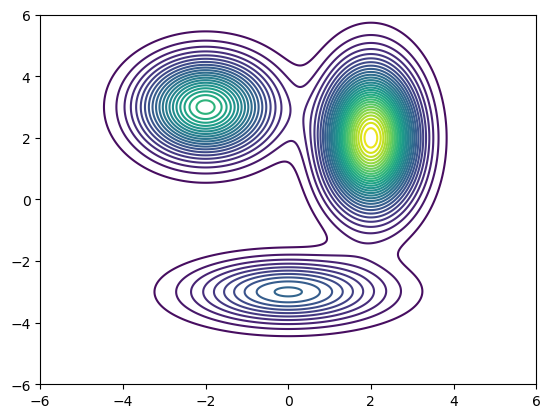

In [7]:
levels = np.linspace(np.min(prob), np.max(prob), 50)
plt.contour(X, Y, prob.clip(max=200), 40);

Here we apply a kernel that deforms the landscape as a function of how non-liner the landscape is locally.

In [8]:
# TODO

Extract N samples from discretized distribution

In [9]:
def sample(prob, samples=1000):
    flat = np.ravel(prob)
    sample_index = np.random.choice(a=flat.size, p=flat, size=samples)
    samples = np.unravel_index(sample_index, prob.shape)
    data = np.array([x[samples[1]], y[samples[0]]]).T
    return data

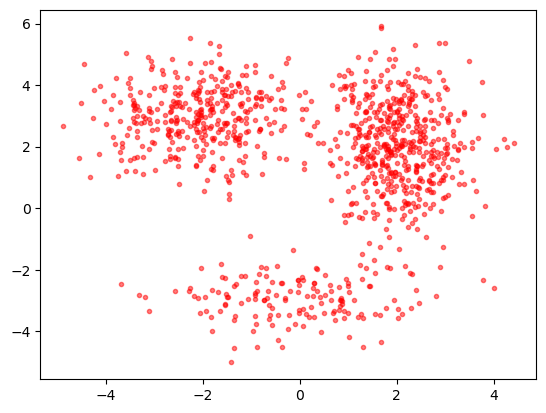

In [10]:
data = sample(prob, 1000)
plt.scatter(data[:, 0], data[:, 1], marker=".", c="r", alpha=0.5);

# MAIN LOOP

In [11]:
# define support (boundaries will depend on where data projects in latent space)
dims = (500, 500)
x = np.linspace(-6, 6, dims[0])
y = np.linspace(-6, 6, dims[1])
X, Y = np.meshgrid(x, y)

gaussians = 3 # number of gaussians to move
loops = 10 # number of iterations for optimizer
samples = 1000 # number of random samples extracted at every optimization step

# initialise parameters (here, just some numbers we like)
# initialisation of  centroids could be done via k-means clustering using Riemaniann metric as distance
params = np.array([0, 2, -2, -3, 2, 3, 1.5, 0.7, 1, 1, 3, 2])

for i in range(loops):

    # generate gaussian landscape
    p = np.reshape(params, (int(len(params)/gaussians), gaussians))
    prob = make_gaussian_landscape(X, Y, *p)

    # produce sampling points from distibution
    data = sample(prob, samples)

    #generate protein for every sampling point

    #simulate SAXS for every protein and calculate their mean

    # calculate error vs experimental data

    # update param array according to error (swarm, gradient descent, ...)